<h1>Принятие решений в бизнесе. Приоритезация гипотез. A/B тест.</h1>

**Описание проекта:**

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. 


**Описание данных:**

Данные для первой части:

*Датасет - hypothesis.csv*
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части:

*Датасет - orders.csv*
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

*Датасет - visitors.csv*

* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

### Загрузгка данных и подготовка их к анализу

<h4>Загрузка данных</h4>

In [1]:
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
hypothesis.info();
print('- - - - - -')
visitors.info();
print('- - - - - -')
orders.info()

display(hypothesis.head(10))
display(visitors.head())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
- - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
- - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tr

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**После загрузки данных:** 
- DF hypothesis, visitors, orders не имеют пропусков;
- названия столбцов не соответствуют змеиному стилю;
- есть некорректные типы данных в столбцах.

<h4>Предобработка данных</h4>

In [5]:
# приведение названий столбцов к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()
visitors.columns = visitors.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [6]:
# приведение к нужному формату данных
visitors['date'] = pd.to_datetime(visitors['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [7]:
print('Количество дубликатов в DF hypothesis:', hypothesis.duplicated().sum())
print('Количество дубликатов в DF visitors:', visitors.duplicated().sum())
print('Количество дубликатов в DF orders:', orders.duplicated().sum())
print()
print('Количество пропусков в DF hypothesis:\n')
print(hypothesis.isnull().sum().sort_values())
print()
print('Количество пропусков в DF visitors:\n')
print(visitors.isnull().sum().sort_values())
print()
print('Количество пропусков в DF orders:\n')
print(orders.isnull().sum().sort_values())

Количество дубликатов в DF hypothesis: 0
Количество дубликатов в DF visitors: 0
Количество дубликатов в DF orders: 0

Количество пропусков в DF hypothesis:

hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

Количество пропусков в DF visitors:

date        0
group       0
visitors    0
dtype: int64

Количество пропусков в DF orders:

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64


In [8]:
hypothesis.info();
print('- - - - - -')
visitors.info();
print('- - - - - -')
orders.info()

display(hypothesis.head(10))
display(visitors.head())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
- - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
- - - - - -
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**Корректность разбиения пользователей на группы:** 

In [9]:
# np.intersect1d - эта функция возвращает только те элементы, которые присутствуют и в первом массиве, и во втором массиве
users_in_both_groups = np.intersect1d(orders[orders['group'] =='A']['visitorid'].unique(), orders[orders['group'] =='B']['visitorid'].unique())

print('Общее количество пользователей теста:', len(orders['visitorid']))
print('Количество пользователей в обеих группах:', len(users_in_both_groups))

Общее количество пользователей теста: 1197
Количество пользователей в обеих группах: 58


In [10]:
# Удаление пользователей вошедших в обе группы теста
orders = orders[np.logical_not(orders['visitorid'].isin(users_in_both_groups))]

print('Количество пользователей в после удаления пользователей попавших в обе группы:', len(orders['visitorid']))

Количество пользователей в после удаления пользователей попавших в обе группы: 1016


**После предобработки данных:** 
- проверено, что DF hypothesis, visitors, orders не имеют пропусков и дубликатов;
- названия столбцов приведены к змеиному стилю (убраны заглавные буквы в названиях);
- изменен тип данных для столбцов с датами на datetime;
- удалены пользователи попавшие в обе группы теста, их количество - 58;
- данные готовы к дальнейшему анализу.

### Приоритизация гипотез

<h4>Применение фреймворка ICE для приоритизации гипотез. Сортировка гипотез по убыванию приоритета</h4>

In [11]:
# расчет ICE
hypothesis['ice'] = (hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False).round()

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


<h4>Применение фреймворка RICE для приоритизации гипотез. Сортировка гипотез по убыванию приоритета</h4>

In [12]:
# расчет RICE
hypothesis['rice'] = (hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
hypothesis[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


<h4>Изменение приоритизации гипотез при использовании RICE вместо ICE</h4>

In [13]:
# Сортировка по RICE
hypothesis = hypothesis.sort_values(by='rice', ascending=False)

# Функция для выделения максимального значения
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')

# Применение функции к столбцам
styled_hypothesis = hypothesis.style.apply(highlight_max, props='color:white;background-color:orange', axis=0, subset=['ice', 'rice'])

# Округление столбцов до 2 знаков после запятой
styled_hypothesis = styled_hypothesis.format(formatter={'ice': '{:.2f}', 'rice': '{:.2f}'}) 

styled_hypothesis

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


**Вывод:**

При применении методики RICE вместо ICE приоритеты гипотез могут измениться из-за того, что RICE учитывает дополнительный показатель - охват `reach`. Он определяет, скольких пользователей затронет изменение, что может значительно влиять на общую эффективность гипотезы.

**Изменения в приоритезации:**

* Гипотеза 7 (добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) осталась в топ-3, но переместилась с 3-го места в ICE на 1-е место в RICE. Это связано с высоким значением `reach` (10) и `impact` (7), которые показывают, что эта гипотеза может затронуть большое количество пользователей и ее влияение высоко.

* Гипотеза 2 (добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа) переместилась с 5-го места в ICE на 2-е место в RICE. Это связано с высоким значением `reach` (8) и `confidence` (7), что говорит о том, что она может охватить большое количество пользователей и иметь успех. 

* Гипотеза 0 (добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей) сохранила свое место, так как у нее высокий `impact` (10) и `confidence` (8).

* Гипотеза 6 (Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию) так же сохранила свое место, так как у нее достаточно высокий `reach` (5) и `confidence` (8) и низкий параметр `efforts` (3).
 
* Гипотеза 8 (запустить акцию, дающую скидку на товар в день рождения) переместилась с 1-го места в ICE на 5-е место в RICE. Это связано с низким значением `reach` (1), что говорит о том, что эта гипотеза не затронет большое количество пользователей.


### Анализ A/B-теста

<h4>Построение графика кумулятивной выручки по группам / Выводы и предположения</h4>

In [14]:
# Создание пар: дата / группа
datesgroups = orders[['date', 'group']].drop_duplicates()

visitors_agg = datesgroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
       .agg({'date': 'max', 'group': 'max', 'visitors': 'sum'})
       ,axis=1,).sort_values(by=['date', 'group'])

orders_agg = datesgroups.apply(lambda x: orders[np.logical_and( orders['date'] <= x['date'], orders['group'] == x['group'])]
       .agg({'date': 'max', 'group': 'max','transactionid': 'nunique','visitorid': 'nunique','revenue': 'sum',})
       ,axis=1,).sort_values(by=['date', 'group'])

cumul_df = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])

cumul_df.columns = ['date','group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивной выручкой по группе А
cumul_revenue_a = cumul_df[cumul_df['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивной выручкой по группе B
cumul_revenue_b = cumul_df[cumul_df['group']=='B'][['date','revenue', 'orders']]

cumul_df.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


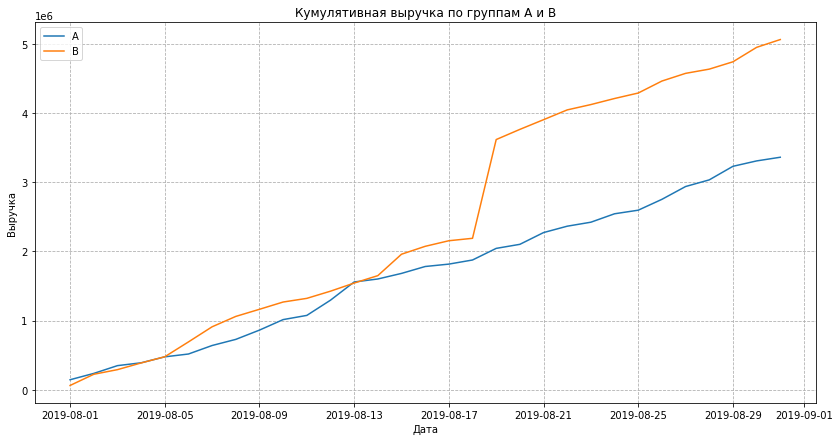

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(cumul_revenue_a['date'], cumul_revenue_a['revenue'], label='A')
plt.plot(cumul_revenue_b['date'], cumul_revenue_b['revenue'], label='B')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по группам A и B')
plt.grid(linestyle='--')
plt.legend()
plt.show()

**Вывод:** 

Анализ данных показал, что кумулятивная выручка группы B превышает выручку группы A, что свидетельствует о положительных изменениях в группе B. Также наблюдается значительный скачок выручки в группе B в период с 2019-08-18 по 2019-08-19, что может быть свидетельством аномалии.

<h4>Построение графика кумулятивного среднего чека по группам / Выводы и предположения</h4>

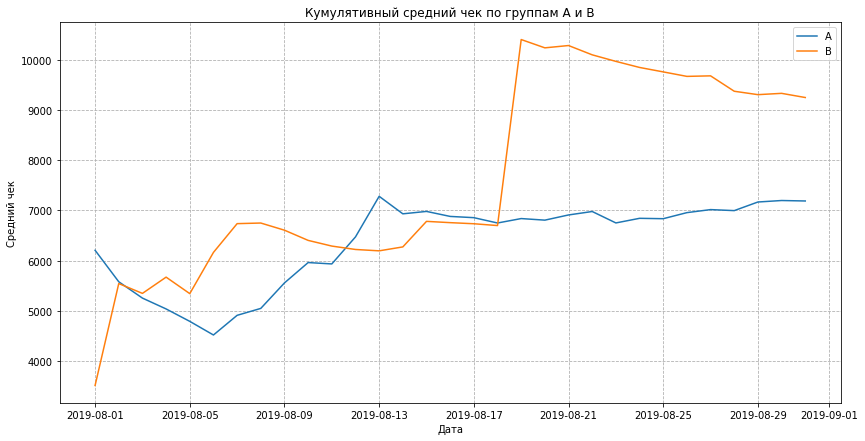

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(cumul_revenue_a['date'], cumul_revenue_a['revenue']/cumul_revenue_a['orders'], label='A')
plt.plot(cumul_revenue_b['date'], cumul_revenue_b['revenue']/cumul_revenue_b['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по группам A и B')
plt.grid(linestyle='--')
plt.legend()
plt.show()

**Вывод:**

С 2019-08-18 по 2019-08-19 в группе В был обнаружен заметный рост кумулятивного среднего чека. Возможно, это аномальное значение которое может оказать влияние на результаты. Следует подробнее изучить данные по группе B.

<h4>Построение графика относительного изменения кумулятивного среднего чека группы B к группе A / Выводы и предположения</h4>

In [17]:
# Объединение данных по группам А и B в одном DF
merged_сumul_revenue = cumul_revenue_a.merge(cumul_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

merged_сumul_revenue.head()

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


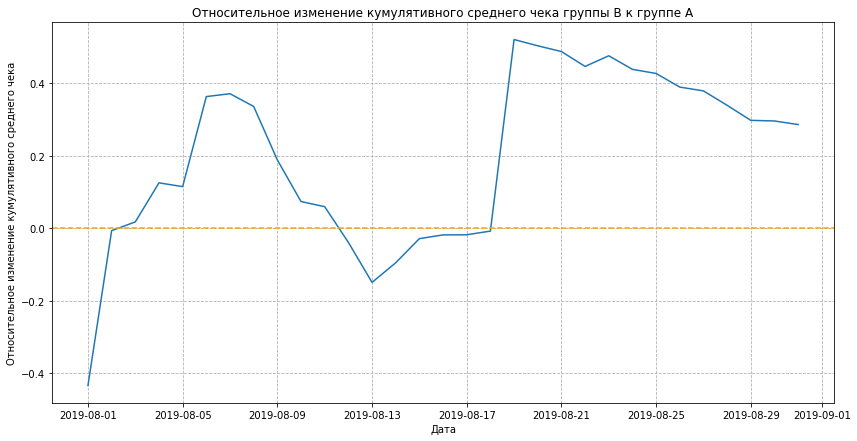

In [18]:
plt.figure(figsize=(14, 7))
plt.plot(merged_сumul_revenue['date'], (merged_сumul_revenue['revenueB']/merged_сumul_revenue['ordersB'])/
         (merged_сumul_revenue['revenueA']/merged_сumul_revenue['ordersA'])-1)
plt.axhline(y=0, color='orange', linestyle='--') 
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего чека')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.grid(linestyle='--')
plt.show()

**Вывод:**

Кумулятивный средний чек группы B превышает кумулятивный средний чек группы A, практически на протяжении всего теста, однако имеются аномальные пики падения (2019-08-13) и резкого возрастания (в районе 2019-08-19).<br><br>
Возможные причины: 
* В группе B были совершены крупные заказы или заказы с аномально высоким средним чеком;
* Технические сбои или ошибки в системе, которые могли изменить данные по заказам и выручке;
* Проведение маркетинговых акций (скидок или специальных предложений) в наблюдаемые периоды могло повлиять на результат теста.

<h4>Построение графика кумулятивного среднего количества заказов на посетителя по группам / Выводы и предположения</h4>

In [19]:
# Расчет кумулятивного среднего количества заказов на посетителя
cumul_df['avg_oreders'] = cumul_df['orders']/cumul_df['visitors']

# Разбивка на группы A и B
cumul_df_a = cumul_df[cumul_df['group']=='A']
cumul_df_b = cumul_df[cumul_df['group']=='B']

display(cumul_df_a.head())
display(cumul_df_b.head())

,date,group,orders,buyers,revenue,visitors,avg_oreders
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


,date,group,orders,buyers,revenue,visitors,avg_oreders
1,2019-08-01,B,17,17,59758,713,0.023843
3,2019-08-02,B,40,39,221801,1294,0.030912
5,2019-08-03,B,54,53,288850,1803,0.029950
7,2019-08-04,B,68,66,385740,2573,0.026428
9,2019-08-05,B,89,87,475648,3280,0.027134


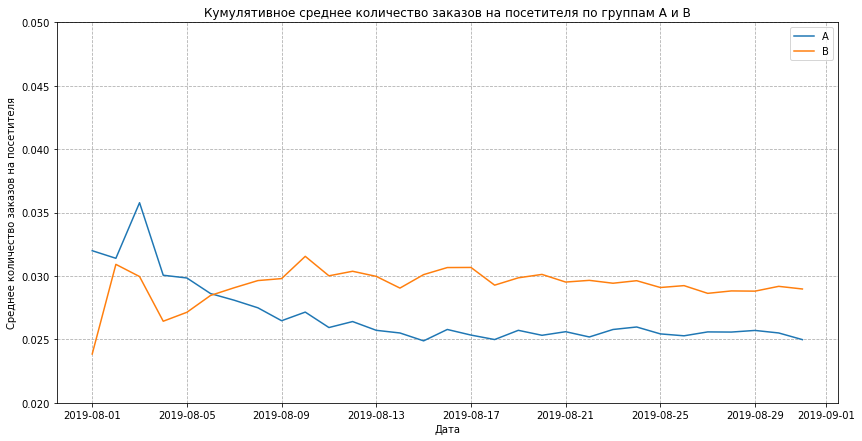

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(cumul_df_a['date'], cumul_df_a['avg_oreders'], label='A')
plt.plot(cumul_df_b['date'], cumul_df_b['avg_oreders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов на посетителя')
plt.title('Кумулятивное среднее количество заказов на посетителя по группам A и B')
plt.grid(linestyle='--')
plt.ylim(0.02, 0.05) # измение масштаба графика, чтобы было видно, что абсолютное значение колебания в начале и в конце теста не слишком большое
plt.legend()
plt.show()

**Вывод:**

В начале теста группа A имела большее кумулятивное среднее количество заказов, но постепенно группа B выровнялась и зафиксировала примерно одно значение, превышающее значение группы A.

<h4>Построение графикa относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A / Выводы и предположения</h4>

In [21]:
# Объединение данных кумулятивного среднего количества заказов на посетителя по группам А и B в одном DF
merged_cumul_avg_orders = cumul_df_a[['date','avg_oreders']].merge(cumul_df_b[['date','avg_oreders']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

merged_cumul_avg_orders.head()

,date,avg_oredersA,avg_oredersB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


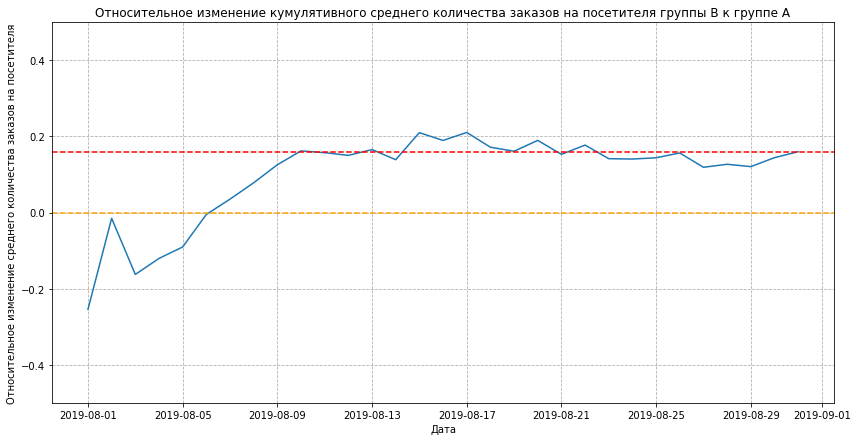

In [22]:
plt.figure(figsize=(14, 7))
plt.plot(merged_cumul_avg_orders['date'], merged_cumul_avg_orders['avg_oredersB']/merged_cumul_avg_orders['avg_oredersA']-1)
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего количества заказов на посетителя')
plt.title('Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.axhline(y=0, color='orange', linestyle='--')
plt.axhline(y=0.16, color='red', linestyle='--')
plt.ylim(-0.5, 0.5)
plt.grid(linestyle='--')
plt.show()

**Вывод:** 

График указывает на то, что группа B демонстрирует большее кумулятивное среднее количество заказов по сравнению с группой A. Средняя конверсия в группе B составляет приблизительно 0.15 - 0.16 и остается стабильной. 

<h4>Построение точечного графика количества заказов по пользователям / Выводы и предположения</h4>

In [23]:
# Расчет количества заказов по пользователям
orders_by_users = (orders.groupby('visitorid', as_index=False).agg({'transactionid': 'nunique'}))

orders_by_users.columns = ['visitorid', 'orders']

orders_by_users.head()

,visitorid,orders
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


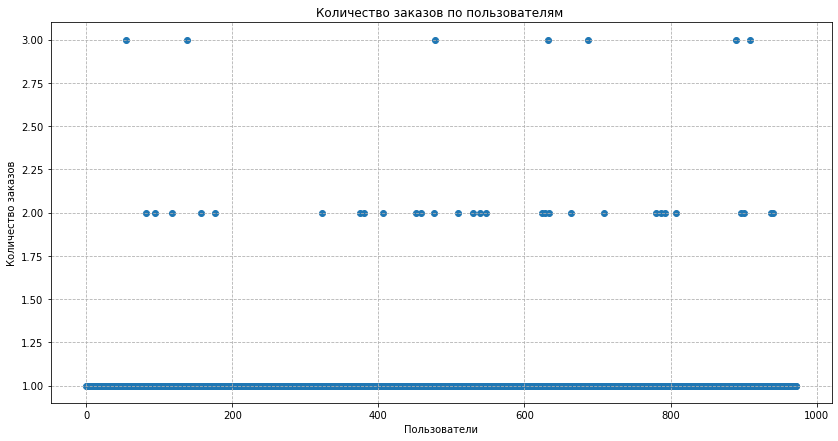

In [24]:
# Cерия из чисел от 0 до количества наблюдений в orders_by_users
x_values = pd.Series(range(0, len(orders_by_users)))

plt.figure(figsize=(14, 7))
plt.scatter(x_values, orders_by_users['orders'])
plt.title('Количество заказов по пользователям ')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.grid(linestyle='--')
plt.show()

**Вывод:** 

Основная часть пользователей сделала только 1 заказ за время теста. Заказов в количестве 2 и более совсем мало. Максимальное количество заказов - 11 штук.

<h4>Расчет 95-ого и 99-ого перцентиля количества заказов на пользователя / Выбор границы для определения аномальных пользователей</h4>

In [25]:
# Рассчитываем перцентили по количеству заказов пользователей
percentiles = np.percentile(orders_by_users['orders'], [95, 99])
print(percentiles)

print(f"Не более 5% пользователей совершали больше {int(percentiles[0])} заказов.")
print(f"И не более 1% пользователей совершали больше {int(percentiles[1])} заказов.")

[1. 2.]
Не более 5% пользователей совершали больше 1 заказов.
И не более 1% пользователей совершали больше 2 заказов.


**Вывод:**   

Примем за аномальных пользователей тех, кто совершил 2 заказа и более.

<h4>Построение точечного графика стоимостей заказов / Выводы и предположения</h4>

In [26]:
orders.sort_values(by='revenue', ascending=False).head()

,transactionid,visitorid,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
743,3603576309,4133034833,2019-08-09,67990,A


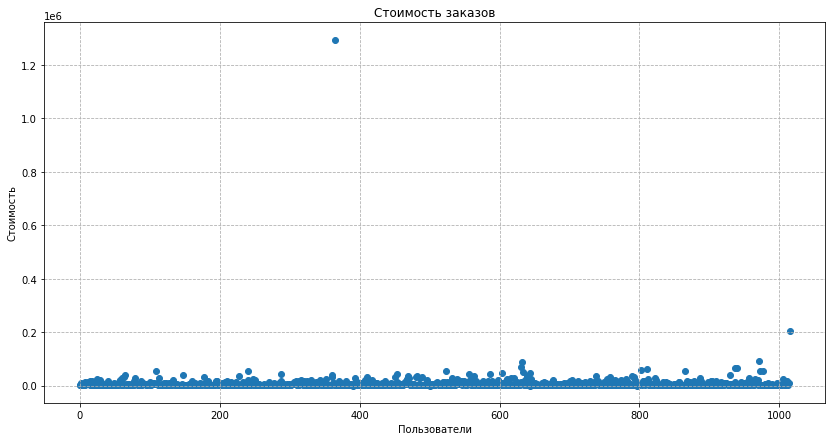

In [27]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(14, 7))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость')
plt.grid(linestyle='--')
plt.show()

**Вывод:** 

Основная часть заказов имеет стоимость не более 10.000. Заказов с аномальной стоимостью 2 - на 202.740 и на 1.294.500.

<h4>Расчет 95-ого и 99-ого перцентиля стоимости заказов / Выбор границы для определения аномальных заказов</h4>

In [28]:
# Рассчитываем перцентили по стоимости заказов
percentiles_orders = np.percentile(orders['revenue'], [95, 99])
print(percentiles_orders)

print(f"Не более 5% пользователей совершали заказы стоимостью более {int(percentiles_orders [0])}.")
print(f"И не более 1% пользователей совершали заказы стоимостью более {int(percentiles_orders [1])}.")

[26785. 53904.]
Не более 5% пользователей совершали заказы стоимостью более 26785.
И не более 1% пользователей совершали заказы стоимостью более 53904.


**Вывод:** 

Возьмём за аномальные, заказы стоимостью выше 26.785.

<h4>Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «сырым» данным / Выводы и предположения</h4>

In [29]:
visitors_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_a.columns = ['date', 'visitors_per_date_a']

visitors_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_b.columns = ['date', 'visitors_per_date_b']

orders_by_users_a = (orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
orders_by_users_a.columns = ['visitorid', 'orders']

orders_by_users_b = (orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
orders_by_users_b.columns = ['visitorid', 'orders'] 

orders_group_a = np.zeros(visitors[visitors['group']=='A']['visitors'].sum() - len(orders_by_users_a))
orders_a = pd.Series(data=orders_group_a, name='orders')

orders_group_b = np.zeros(visitors[visitors['group']=='B']['visitors'].sum() - len(orders_by_users_b))
orders_b = pd.Series(data=orders_group_b, name='orders')

<b>Гипотеза Н0</b>: Нет статистически значимой разницы в среднем количестве заказов на посетителя между группой A и группой B.<br>
<b>Гипотеза Н1</b>: Существует статистически значимая разница в среднем количестве заказов на посетителя между группой A и группой B. 

In [30]:
test_a = pd.concat([orders_by_users_a['orders'], orders_a], axis=0)
test_b = pd.concat([orders_by_users_b['orders'], orders_b], axis=0)

In [31]:
print(f"p-value: {stats.mannwhitneyu(test_a, test_b)[1]:.3f}")      
print(f"Относительное изменение среднего: {test_b.mean() / test_a.mean() - 1:.3f}")

p-value: 0.011
Относительное изменение среднего: 0.160


**Вывод:** Отвергаем нулевую гипотезу.
* p-value: 0.011 - это значение ниже стандартного порога значимости (0.05), поэтому, существуют достаточные основания  утверждать, что различия в среднем количестве заказов между группами статистически значимы.
* Относительное изменение среднего: 0.160. Среднее количество заказов в группе B на 16 выше, чем в группе A. 

<h4>Расчет статистической значимости различий в среднем чеке заказа между группами по «сырым» данным / Выводы и предположения</h4>

<b>Гипотеза Н0</b>: Нет статистически значимой разницы в среднем чеке заказа между группой A и группой B.<br>
<b>Гипотеза Н1</b>: Существует статистически значимая разница в среднем чеке заказа между группой A и группой B.

In [32]:
print(f"p-value: {stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]:.3f}")
print(f"Относительное изменение среднего: {orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1:.3f}") 

p-value: 0.829
Относительное изменение среднего: 0.287


**Вывод:** Не получилось отвергнуть нулевую гипотезу. 

В группе B наблюдается увеличение среднего чека на 28.7%, что является существенным изменением. Однако, отсутствие статистической значимости может указывать на то, что это изменение может быть случайным и не связано с тестируемым изменением.

* p-value: 0.829 - это значение выше стандартного порога значимости (0.05). Нет достаточных оснований утверждать, что различия  в среднем чеке заказа между группами статистически значимы.
* Относительное изменение среднего: 0.287. Средний чек в группе B на 28.7% выше, чем в группе A.

<h4>Расчет статистической значимости различий в среднем количестве заказов на посетителя между группами по «очищенным» данным / Выводы и предположения</h4>

In [33]:
# Группировка аномальных значений
lim_orders = 2
lim_revenue = 26785

anomaly_orders = pd.concat([
        orders_by_users_a[orders_by_users_a['orders'] > lim_orders]['visitorid'],
        orders_by_users_b[orders_by_users_b['orders'] > lim_orders]['visitorid']], axis=0,)

anomaly_users = orders[orders['revenue'] > lim_revenue]['visitorid']

anomaly = (pd.concat([anomaly_orders, anomaly_users], axis=0).drop_duplicates().sort_values())

print('Количество аномальных пользователей:', len(anomaly))

Количество аномальных пользователей: 58


<b>Гипотеза Н0</b>: Нет статистически значимой разницы в среднем количестве заказов на посетителя между группой A и группой B.<br>
<b>Гипотеза Н1</b>: Существует статистически значимая разница в среднем количестве заказов на посетителя между группой A и группой B. 

In [34]:
# Очищенные от аномалий данные
test_a_ftl = pd.concat([orders_by_users_a[np.logical_not(orders_by_users_a['visitorid'].isin(anomaly))]['orders'],
        pd.Series(0, index=np.arange(visitors_a['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')], axis=0)

test_b_ftl = pd.concat([orders_by_users_b[np.logical_not(orders_by_users_b['visitorid'].isin(anomaly))]['orders'],
        pd.Series(0, index=np.arange(visitors_b['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')], axis=0) 

In [35]:
print(f"p-value: {stats.mannwhitneyu(test_a_ftl, test_b_ftl)[1]:.3f}")
print(f"Относительное изменение среднего: {test_b_ftl.mean()/test_a_ftl.mean()-1:.3f}") 

p-value: 0.012
Относительное изменение среднего: 0.182


**Вывод:** Отвергаем нулевую гипотезу.

После очистки данных от аномальных значений различия в среднем количестве заказов между группами статистически значимы. 
* p-value: 0.012 - это значение ниже стандартного порога значимости (0.05), поэтому, существуют достаточные основания  утверждать, что различия в среднем количестве заказов между группами статистически значимы.
* Относительное изменение среднего: 0.182. Среднее количество заказов в группе B на 18.2% выше, чем в группе A.

<h4>Расчет статистической значимости различий в среднем чеке заказа между группами по «очищенным» данным / Выводы и предположения</h4>

<b>Гипотеза Н0</b>: Нет статистически значимой разницы в среднем чеке заказа между группой A и группой B.<br>
<b>Гипотеза Н1</b>: Существует статистически значимая разница в среднем чеке заказа между группой A и группой B.

In [36]:
print(f"p-value: {stats.mannwhitneyu(orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(anomaly)))]['revenue'], orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(anomaly)))] ['revenue'])[1]:.3f}") 
print(f"Относительное изменение среднего: {orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorid'].isin(anomaly)))]['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorid'].isin(anomaly)))]['revenue'].mean() - 1:.3f}")

p-value: 0.646
Относительное изменение среднего: -0.048


**Вывод:** Не получилось отвергнуть нулевую гипотезу. 

По результатам статистического теста Mann-Whitney U на основе очищенных данных, нет статистически значимой разницы в среднем чеке заказа между группами A и B. В целом можно сделать вывод, что проведенные тесты не показали существенного влияния тестируемых факторов на средний чек заказа.
* p-value: 0.646 - это значение выше стандартного порога значимости (0.05). Нет достаточных оснований утверждать, что различия  в среднем чеке заказа между группами статистически значимы.
* Несмотря на наблюдаемое снижение 4.8%, это различие не является статистически значимым. 

### Решение по A/B-тесту

**По итогам исследования данных можно утверждать:**
* Группа B показывает лучшие показатели по сравнению с группой A;

* Различия в среднем чеке между группами не имеют статистической значимости, даже после очистки данных от аномальных значений;

* В "сырых" и "очищенных" данных различия в среднем количестве заказов между группами статистически значимы, среднее количество заказов по результатам "очищенных" данных в группе B на 18.2% выше, чем в группе A. 

В связи с этим, рекомендуется завершить тестирование, поскольку продолжение его исполнения не принесет значительных изменений.
